In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

## Load and split data
train_csv = 'data/train.csv'
test_csv = 'data/test.csv'

train_data = np.genfromtxt(train_csv, delimiter=',', skip_header=1)
target_X = np.genfromtxt(test_csv, delimiter=',', skip_header=1)

train_X, valid_X, train_y, valid_y = train_test_split(train_data[:,1:], train_data[:,0], test_size = 0.3, random_state=1)
valid_X, test_X, valid_y, test_y = train_test_split(valid_X, valid_y, test_size = 0.25, random_state=1)

# Normalize
train_X /= 255
valid_X /= 255
test_X /= 255
target_X /= 255

# Count
print('Number of train data: {}'.format(train_X.shape[0]))
print('Number of valid data: {}'.format(valid_X.shape[0]))
print('Number of test data: {}'.format(test_X.shape[0]))
print('Number of target data: {}'.format(target_X.shape[0]))

Number of train data: 29400
Number of valid data: 9450
Number of test data: 3150
Number of target data: 28000


In [9]:
# Image Augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    #shear_range=0.5
    rotation_range=20,
    zoom_range=0.2,
    #width_shift_range=0.5,
    #height_shift_range=0.5,
    #horizontal_flip=False,
    #vertical_flip=False
)

datagen.fit(train_X.reshape(-1, 28, 28, 1))

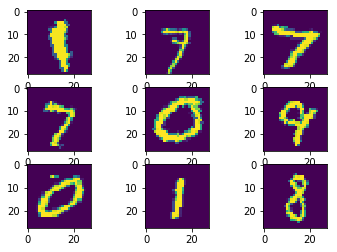

In [10]:
from keras.utils.np_utils import to_categorical

# Visualizing augmented data
import matplotlib.pyplot as plt
%matplotlib inline

for x_batch, y_batch in datagen.flow(train_X.reshape([-1, 28, 28, 1]), to_categorical(train_y, num_classes=10), batch_size=9):
    for i, x in enumerate(x_batch):
        plt.subplot(330 + i + 1)
        plt.imshow(x.reshape([28,28]))
        
    break

In [11]:
# Build Model
from keras.layers import MaxPool2D, Conv2D, Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, InputLayer
from keras.models import Sequential

NETWORK = 3

model = Sequential()
model.add(InputLayer(input_shape=(28, 28, 1)))
    
if NETWORK == 0:
    # 0.98128
    model.add(Conv2D(filters=16, kernel_size=3, strides=1, activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(100, activation='tanh'))

elif NETWORK == 1:
    # 0.98714 - using GAP
    # 0.99142 - Using Flatten - Dense - no dropout - 50 epochs
    model.add(Conv2D(filters=16, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='tanh'))
    #model.add(Dropout(rate=0.25))
    # GAP
    #model.add(GlobalAveragePooling2D())

elif NETWORK == 2:
    # 0.99257 - 32x3x3 - 64x3x3 - Flatten - Dense(512)
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPool2D())
    model.add(Dropout(rate=0.5))
    
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPool2D())
    model.add(Dropout(rate=0.5))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(rate=0.5))
    

elif NETWORK == 3:
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPool2D())
    model.add(Dropout(rate=0.5))
    
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPool2D())
    model.add(Dropout(rate=0.5))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(rate=0.5))

    
model.add(Dense(10, activation='softmax'))


from keras.optimizers import RMSprop, Adam, Adamax
model.compile(optimizer=Adamax(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        36928     
__________

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping  

epochs = 100

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.hdf5', 
                               verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

### Train with raw data ###
#model.fit(train_X.reshape([-1, 28, 28, 1]), to_categorical(train_y, num_classes=10), 
#          validation_data=(valid_X.reshape([-1, 28, 28, 1]), to_categorical(valid_y, num_classes=10)),
#          epochs=epochs, batch_size=20, callbacks=[checkpointer, earlystopper], verbose=0)

### Train with augmented data ###
model.fit_generator(datagen.flow(train_X.reshape([-1, 28, 28, 1]), to_categorical(train_y, num_classes=10), batch_size=20),
                    validation_data=(valid_X.reshape([-1, 28, 28, 1]), to_categorical(valid_y, num_classes=10)),
                    steps_per_epoch=len(train_X) / 20, epochs=epochs, callbacks=[checkpointer, earlystopper], verbose=0)

Epoch 00000: val_loss improved from inf to 0.06547, saving model to saved_models/weights.best.hdf5
Epoch 00001: val_loss improved from 0.06547 to 0.04973, saving model to saved_models/weights.best.hdf5
Epoch 00002: val_loss improved from 0.04973 to 0.04062, saving model to saved_models/weights.best.hdf5
Epoch 00003: val_loss improved from 0.04062 to 0.03874, saving model to saved_models/weights.best.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 0.03874 to 0.03252, saving model to saved_models/weights.best.hdf5
Epoch 00007: val_loss improved from 0.03252 to 0.03076, saving model to saved_models/weights.best.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss improved from 0.03076 to 0.03025, saving model to saved_models/weights.best.hdf5
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss improved from 0.03025 to 0.02957, saving model to saved_models/weights.best.hdf5
Epoch 00012: val_loss improv

In [6]:
model.load_weights('saved_models/weights.best.hdf5')

train_y_hat = model.predict(train_X.reshape([-1, 28, 28, 1]))
print('Training   Accuracy: {:.4f}'.format(np.mean(np.argmax(train_y_hat, axis=1) == train_y)))

valid_y_hat = model.predict(valid_X.reshape([-1, 28, 28, 1]))
print('Validation Accuracy: {:.4f}'.format(np.mean(np.argmax(valid_y_hat, axis=1) == valid_y)))

test_y_hat = model.predict(test_X.reshape([-1, 28, 28, 1]))
print('Test       Accuracy: {:.4f}'.format(np.mean(np.argmax(test_y_hat, axis=1) == test_y)))

Training   Accuracy: 0.9935
Validation Accuracy: 0.9904
Test       Accuracy: 0.9930


In [7]:
# Generate Target prediction for submition
target_y_hat = model.predict(target_X.reshape([-1, 28, 28, 1]))
target_y_hat = np.argmax(target_y_hat, axis=1)

In [8]:
# Output as format required
target_y_hat_pd = pd.DataFrame(target_y_hat, columns=['Label'])
target_y_hat_pd.index += 1
target_y_hat_pd.index.name = 'ImageId'
target_y_hat_pd.to_csv('predition.csv')